# Masking Options

In [1]:
import numpy as np
import os.path as op
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Masking Description

In this dataset, each spectrum is associated with a bitmask that encodes various data quality flags. These flags help identify pixels or fibers that may be affected by instrumental issues, reduction artifacts, or observational anomalies. Each bit in the mask corresponds to a specific condition, and multiple flags can be combined in a single value using bitwise operations.
The table below lists all the possible flags, their hexadecimal and binary representations, and descriptions of what each flag indicates. 

| Hex Value   | Binary         | Integer Value | Name       | Description                                                                 |
|-------------|----------------|----------------|------------|-----------------------------------------------------------------------------|
| 0x00000000  | 0              | 0              | Good       | No flag                                                                     |
| 0x00000001  | 1              | 1              | MAIN       | Value flagged in reduction (`calfibe == 0.0`)                               |
| 0x00000002  | 10             | 2              | FTF        | Average fiber-to-fiber in spectrum is > 0.5                                 |
| 0x00000004  | 100            | 4              | CHI2FIB    | `chi2fib > 150`                                                             |
| 0x00000008  | 1000           | 8              | BADPIX     | On a newly found bad pixel region                                           |
| 0x00000010  | 10000          | 16             | BADAMP     | On a bad amplifier                                                          |
| 0x00000020  | 100000         | 32             | LARGEGAL   | Located within a large galaxy mask                                          |
| 0x00000040  | 1000000        | 64             | METEOR     | On a known meteor track                                                     |
| 0x00000080  | 10000000       | 128            | BADSHOT    | In bad shot list                                                            |
| 0x00000100  | 100000000      | 256            | THROUGHPUT | `response_4540 < 0.08`                                                      |
| 0x00000200  | 1000000000     | 512            | BADFIB     | On a known bad fiber                                                        |
| 0x00000400  | 10000000000    | 1024           | SAT        | On a known satellite track                                                  |
| 0x00000800  | 100000000000   | 2048           | BADCAL     | Wavelength dependent masking due to sky and calibration issues             |
| 0x00001000  | 1000000000000  | 4096           | PIXMASK    | Wavelength dependent masking due to `spectrum == 0` in native spectrum counts |


In [2]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
plt.rcParams.update({'font.size': 12})

In [3]:
pdr_dir = '/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/'
if not op.exists(pdr_dir):
    pdr_dir = '/home/jovyan/work/pdr1/'

In [4]:
shotid = 20190405020
ifuslot = '034'

In [5]:
datacube_path = op.join( pdr_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))

Each IFU datacube is named as `dex_cube_<SHOTID>_<IFUSLOT>.fits`, where:

- `<SHOTID>` corresponds to the observation ID (e.g., `20240731009`)
- `<IFUSLOT>` is the unique identifier of the IFU (e.g., `013`, `106`)

Each FITS file contains a 3D datacube organized as `(wavelength, y, x)` with:
- **Spectral resolution:** 1036 bins at 2 Å per pixel
- **Spatial resolution:** 104 × 104 pixels at 0.5 arcsec per pixel

| Extension | EXTNAME | Description                                                | Data Shape     |
|-----------|---------|------------------------------------------------------------|----------------|
| 0         | PRIMARY | Primary HDU (header only, no data)                         | None           |
| 1         | DATA    | Flux datacube in units of erg s⁻¹ cm⁻² Å⁻¹                | (104, 104, 1036) |
| 2         | ERROR   | 1σ error estimates (same units as DATA)                    | (104, 104, 1036) |
| 3         | MASK    | Bitmask per voxel indicating quality flags                 | (104, 104, 1036) |

Let's explore an example datacube:

In [6]:
hdul = fits.open( datacube_path)

In [7]:
hdul.info()

Filename: /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20190405020/dex_cube_20190405020_034.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  DATA          1 CompImageHDU     75   (104, 104, 1036)   float32   
  2  ERROR         1 CompImageHDU     75   (104, 104, 1036)   float32   
  3  MASK          1 CompImageHDU     75   (104, 104, 1036)   int16   


In [8]:
flux = hdul["DATA"].data
error = hdul["ERROR"].data
mask = hdul["MASK"].data
header = hdul["DATA"].header
wcs = WCS(header)

In [9]:
# Select a wavelength slice (e.g., central wavelength)
z_index = 950

# Get corresponding wavelength (in Å)
wavelength_angstrom = wcs.wcs_pix2world(0, 0, z_index, 0)[2]

# Slice the cube at the wavelength index
flux_slice = flux[z_index, :, :]
error_slice = error[z_index, :, :]
mask_slice = mask[z_index, :, :]

In [10]:
# Define which flags to mask out (bitwise OR of values you want to exclude)
# For example, exclude MAIN (1), BADPIX (8), BADFIB (512), and PIXMASK (4096)
mask_flags = 1 | 8 | 512 | 4096

# Create boolean mask where any of these flags are set
bad_mask = (mask_slice & mask_flags) != 0

# Apply the mask by setting bad values to NaN (or zero if preferred)
flux_masked = np.where(bad_mask, np.nan, flux_slice)
error_masked = np.where(bad_mask, np.nan, error_slice)

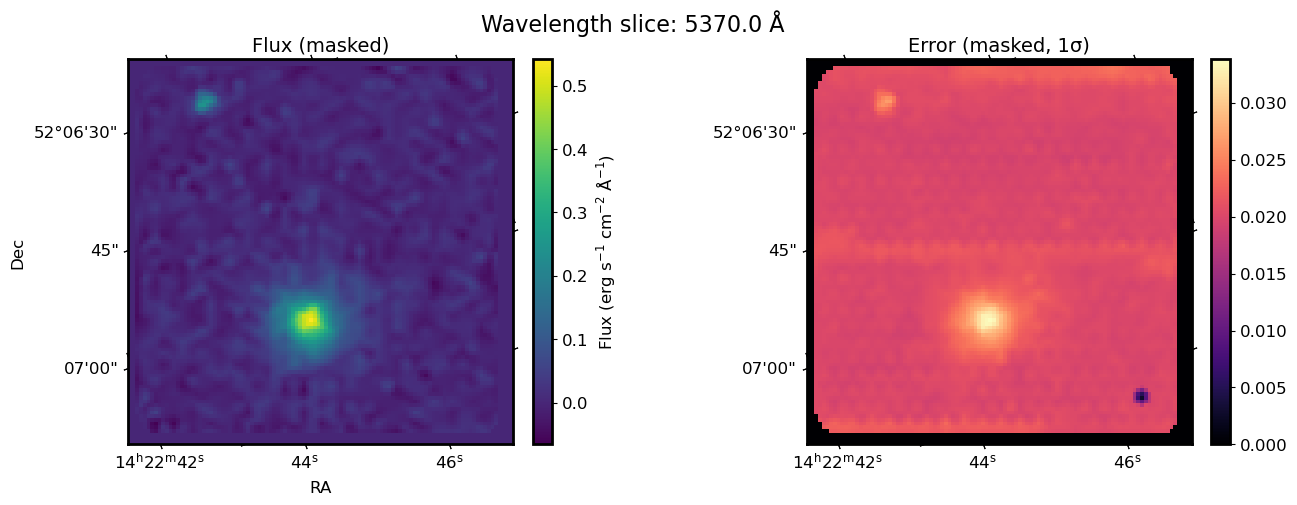

In [11]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': wcs.celestial})
plt.subplots_adjust(wspace=0.4)

# Shared image display settings
im_kwargs = dict(origin='lower', interpolation='none')

# Panel 1: Flux
im0 = axes[0].imshow(flux_masked, cmap='viridis', **im_kwargs)
axes[0].set_title("Flux (masked)", fontsize=14)

axes[0].set_xlabel("RA", fontsize=12)
axes[0].set_ylabel("Dec", fontsize=12)
axes[0].coords[0].set_axislabel('RA')
axes[0].coords[1].set_axislabel('Dec')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")

# Panel 2: Error
im1 = axes[1].imshow(error_masked, cmap='magma', **im_kwargs)
axes[1].set_title("Error (masked, 1σ)", fontsize=14)
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords[0].set_axislabel('')
axes[1].coords[1].set_axislabel('')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Title with wavelength
plt.suptitle(f"Wavelength slice: {wavelength_angstrom:.1f} Å", fontsize=16)

plt.show()

In [12]:
# close the fits HDU when done
hdul.close()

## Example of selecting fibers with meteors using the bitmask

In [13]:
from astropy.table import Table

Open IFU index table to locate IFU cubes with meteors

In [14]:
ifu_data = Table.read(op.join( pdr_dir, 'ifu-index.fits'))

In [15]:
# find a frame where the fraction flagged by a meteor is greater than 50%
met_indices = np.where( ifu_data['flag_meteor']<0.5)[0]

In [16]:
ifu_data[met_indices]

shotid,ifuslot,ra_cen,dec_cen,flag,flag_badamp,flag_badfib,flag_meteor,flag_satellite,flag_shot,flag_throughput,field,objid,date,obsid,ra_shot,dec_shot,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,ambtemp,datevobs,dewpoint,exptime,humidity,mjd,nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra
int64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,bytes12,float32,float32,float32,float32,int32,int32,float32,float32,bytes7,float32,float32,float32
20170225014,093,189.11832,62.285686,0.495,1.0,1.0,0.495,1.0,1.0,1.0,goods-n,GN8b_W,20170225,14,189.000267,62.195481,324.458398,14,1.6776817,0.27915552,0.1206,5.5783334,20170225v014,-16.3165,367.38266,17.094,57809.438,8,1,798.03625,340.90582,1029291,62.197292,323.07156,189.003
20180113012,105,163.58266,51.00454,0.362,0.75,1.0,0.497,1.0,1.0,1.0,dex-spring,HS0013_000_E,20180113,12,163.537555,51.127203,70.754157,28,1.6654035,0.412208,0.153,6.7433333,20180113v012,-6.9694443,366.8663,34.236,58131.316,9,1,806.6715,43.182743,0733434,51.1279,69.35363,163.54034
20180113012,074,163.58073,51.092377,0.492,1.0,1.0,0.492,1.0,1.0,1.0,dex-spring,HS0013_000_E,20180113,12,163.537555,51.127203,70.754157,28,1.6654035,0.412208,0.153,6.7433333,20180113v012,-6.9694443,366.8663,34.236,58131.316,9,1,806.6715,43.182743,0733434,51.1279,69.35363,163.54034
20180113012,043,163.57877,51.18028,0.49,1.0,0.998,0.492,1.0,1.0,1.0,dex-spring,HS0013_000_E,20180113,12,163.537555,51.127203,70.754157,28,1.6654035,0.412208,0.153,6.7433333,20180113v012,-6.9694443,366.8663,34.236,58131.316,9,1,806.6715,43.182743,0733434,51.1279,69.35363,163.54034
20180113014,075,176.11699,51.084854,0.48,1.0,1.0,0.48,1.0,1.0,1.0,dex-spring,HS0087_000_E,20180113,14,176.116771,51.126983,70.821207,28,1.8214096,0.27807188,0.1489,6.8733335,20180113v014,-7.333889,370.0492,33.171,58131.35,12,1,806.8408,43.19244,0825474,51.1279,69.364006,176.1192
20180321013,094,207.42201,51.039925,0.469,1.0,1.0,0.469,1.0,1.0,1.0,dex-spring,HS00380_000_E,20180321,13,207.349975,51.127313,70.873514,28,2.0103114,0.30402187,0.1242,11.759444,20180321v013,-8.787778,367.833,20.62,58198.254,12,1,802.3708,43.16395,0603396,51.1279,69.33351,207.3495
20180321013,073,207.43489,51.101562,0.481,1.0,1.0,0.481,1.0,1.0,1.0,dex-spring,HS00380_000_E,20180321,13,207.349975,51.127313,70.873514,28,2.0103114,0.30402187,0.1242,11.759444,20180321v013,-8.787778,367.833,20.62,58198.254,12,1,802.3708,43.16395,0603396,51.1279,69.33351,207.3495
20180420006,103,191.2856,51.48072,0.445,1.0,1.0,0.445,1.0,1.0,1.0,dex-spring,HS00256d2_W,20180420,6,191.269825,51.349169,292.802832,36,3.2,0.0,0.0897,10.892777,20180420v006,-0.064444445,367.46573,77.537,58228.34,9,1,802.3708,317.41278,0809587,51.3479,291.319,191.2695
20180420006,094,191.30942,51.444435,0.44,1.0,1.0,0.44,1.0,1.0,1.0,dex-spring,HS00256d2_W,20180420,6,191.269825,51.349169,292.802832,36,3.2,0.0,0.0897,10.892777,20180420v006,-0.064444445,367.46573,77.537,58228.34,9,1,802.3708,317.41278,0809587,51.3479,291.319,191.2695


In [17]:
#randomly pick an IFU from list above
rand_index=45
shotid = ifu_data['shotid'][met_indices][rand_index]
ifuslot = ifu_data['ifuslot'][met_indices][rand_index]

In [18]:
datacube_path = op.join( pdr_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))

In [19]:
if not op.exists( datacube_path):
    print('Datacube path is not found. Please report.' )
else:
    print('Opening:', datacube_path)

Opening: /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20220310023/dex_cube_20220310023_080.fits


In [20]:
#Open file
hdul = fits.open( datacube_path)

In [21]:
flux = hdul["DATA"].data
error = hdul["ERROR"].data
mask = hdul["MASK"].data
header = hdul["DATA"].header
wcs = WCS(header)

In [22]:
wave_array = np.linspace(3470, 5540, 1036)

In [23]:
# Slice the cube at the wavelength index where a meteor emission line is known

z_index = np.where( wave_array > 3836)[0][0]

wave_slice = wave_array[z_index]
flux_slice = flux[z_index, :, :]
error_slice = error[z_index, :, :]
mask_slice = mask[z_index, :, :]

If you want to apply all mask flags except one—in this case, exclude METEOR (mask bit = 64)—you can do this by:
1. Defining a mask that includes all possible flags.
2. Removing the METEOR flag using bitwise operations.


In [24]:
# METEOR flag value
meteor_flag = 64

# Create a boolean mask where only the METEOR flag is set
meteor_mask = (mask_slice & meteor_flag) != 0

# Optional: exclude cases where other flags are also set
# This ensures we get only pixels *solely* flagged as METEOR
# Uncomment the next line if you want that stricter version:
# meteor_mask = (mask_slice == meteor_flag)

# Apply the mask to isolate METEOR-flagged regions
flux_meteor = np.where(meteor_mask, flux_slice, np.nan)
error_meteor = np.where(meteor_mask, error_slice, np.nan)

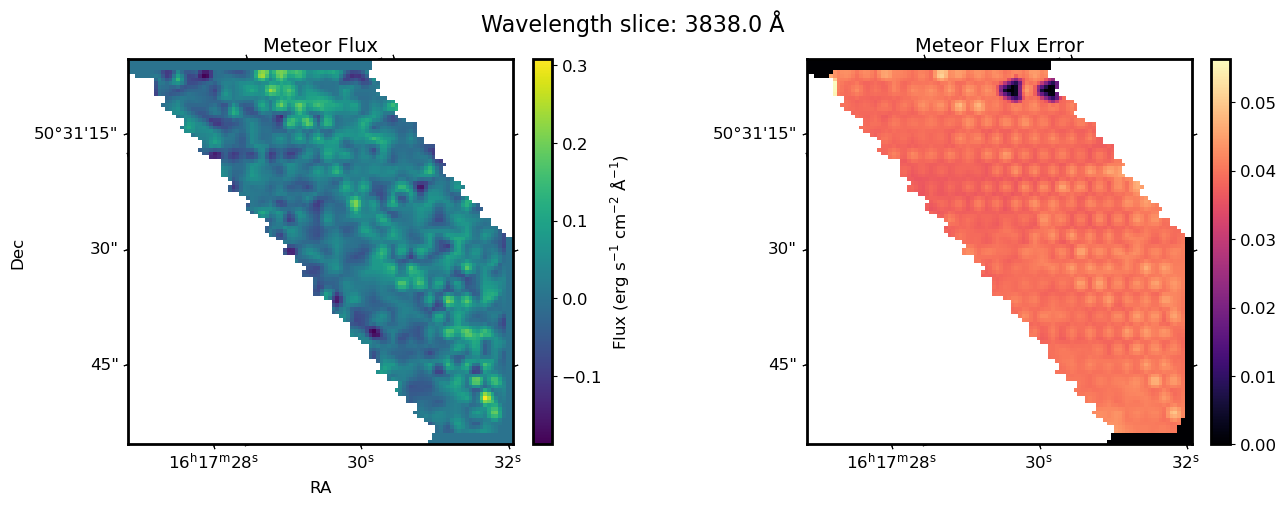

In [25]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': wcs.celestial})
plt.subplots_adjust(wspace=0.4)

# Shared image display settings
im_kwargs = dict(origin='lower', interpolation='none')

# Panel 1: Flux
im0 = axes[0].imshow(flux_meteor, cmap='viridis', **im_kwargs)
axes[0].set_title("Meteor Flux", fontsize=14)

axes[0].set_xlabel("RA", fontsize=12)
axes[0].set_ylabel("Dec", fontsize=12)
axes[0].coords[0].set_axislabel('RA')
axes[0].coords[1].set_axislabel('Dec')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")

# Panel 2: Error
im1 = axes[1].imshow(error_meteor, cmap='magma', **im_kwargs)
axes[1].set_title("Meteor Flux Error", fontsize=14)
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords[0].set_axislabel('')
axes[1].coords[1].set_axislabel('')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Title with wavelength
plt.suptitle(f"Wavelength slice: {wave_slice:.1f} Å", fontsize=16)

plt.show()